In [142]:
import math
import pickle
import time
from functools import reduce

import dask.dataframe as ddf
import jqdatasdk as jq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from csmarapi.CsmarService import CsmarService
from plotly.subplots import make_subplots
from scipy import stats

from utils.my_cache import cache_wrapper

csmar = CsmarService()
from csmarapi.ReportUtil import ReportUtil

jq.auth('13764432461', 'Swisschina6')
csmar.login('wuhh@pbcsf.tsinghua.edu.cn', 'whh8803582')

Fri 07 Oct 2022 09:43:59 CsmarService.py INFO User login succeed


## **I. Data**

Source:

**Data for Research**

- Most Data : `CSMAR`

    - nav

    - dividend

    - split ratio

    - money allocation   

- Fund classification : `JoinQuant`

- Fund start date: `JoinQuant`

**Data for Validation**

- `AMAC` : [page 15](https://www.amac.org.cn/researchstatistics/publication/zgzqtzjjynb/202104/t20210419_11390.html), for market statistic

- `Win.d` : classification/share/nav, for market statistic

*Split ratio is exclusively available in CSMAR!*

<span style="color:blue">Data is true, reliable and available to fetch</span>

AMAC

In [143]:
amac = pd.read_csv('data/AMAC/amac.csv', sep='\t', index_col=0).astype(float)
amac.index = pd.to_datetime(amac.index.astype(str)) + pd.Timedelta('180 days')

JoinQuant

In [144]:
@cache_wrapper(expire = 60 * 60 * 24 * 7)
# cache to avoid unnecessary traffic
def brief_of_funds(frequency : str = time.strftime('%W')) -> pd.DataFrame:
    return jq.get_all_securities(['fund', 'open_fund'], time.strftime('%Y%m%d'))


@cache_wrapper(expire = 60 * 60 * 24 * 7)
def main_info(fund_codes, frequency : str = time.strftime('%W')) -> pd.DataFrame:
    '''
    if you want to modify this function, delete cache and go on
    '''
    limit = jq.DBTable.RESULT_ROWS_LIMIT
    fund_code_cuts = np.array_split(fund_codes, math.ceil(len(fund_codes) / limit))
    full_table_cuts = []
    for code_cut in fund_code_cuts:
        # NOTE `in` is not applicable in filter, use `in_()` defined by joinquant
        table_cut = jq.finance.run_query(jq.query(jq.finance.FUND_MAIN_INFO).filter(jq.finance.FUND_MAIN_INFO.main_code.in_(code_cut)))
        full_table_cuts.append(table_cut)
    full_table = pd.concat(full_table_cuts).reset_index(drop=True)
    full_table['start_date'] = full_table.start_date.astype(np.datetime64).dt.to_period('M')
    return full_table


In [145]:
brief = brief_of_funds()
fund_codes = brief.index.str.split('.').str[0]
fund_main_info = main_info(fund_codes)

fund_main_info_ = fund_main_info[['main_code', 'underlying_asset_type']]

Win.d

In [146]:
wind_share_nav = pd.read_excel('data/Win.d/wind_share_nav.xlsx', sheet_name='Sheet1')
wind_classification = wind_share_nav[['证券代码', '投资类型(一级分类)']]
wind_share_nav = pd.DataFrame(data=wind_share_nav.iloc[:, 3:].values, index=wind_share_nav.证券代码.values, \
    columns = pd.MultiIndex.from_tuples(list(map(lambda x: (x[:4], pd.to_datetime(x[12:22])), wind_share_nav.columns[3:])))).T.sort_index()
wind_share_nav.index = wind_share_nav.index.set_levels(wind_share_nav.index.levels[1].to_period('M'), level=1)

CSMAR

In [147]:
maininfo = pd.read_csv('data/CSMAR/FUND_MainInfo.csv', parse_dates=['InceptionDate'])
maininfo['InceptionDate'] = maininfo.InceptionDate.dt.to_period('M')

symbol_code_mapping = pd.read_csv('data/CSMAR/FUND_FundCodeInfo.csv')
symbol_code_mapping = symbol_code_mapping[['MasterFundCode', 'Symbol']].drop_duplicates()
symbol_code_mapping['Symbol'] = symbol_code_mapping.Symbol.astype(str).str.zfill(6)

share_info = pd.read_csv('data/CSMAR/Fund_ShareChange.csv', parse_dates=['EndDate'])
share_info = share_info.rename(columns={'EndDate': 'Date'})
share_info['Date'] = share_info.Date.dt.to_period('M')
share_info['Symbol'] = share_info.Symbol.astype(str).str.zfill(6)
# share_info = share_info.set_index('Date').sort_index()

nav_daily = ddf.read_csv('data/CSMAR/daily_nav/*').compute()
nav_daily = nav_daily.rename(columns={'TradingDate': 'Date'})
# * heavy time complexity
# * if change Symbol to String now, program will be much slower
# nav_daily['Symbol'] = nav_daily.Symbol.astype(str).str.zfill(6)
nav_daily['Date'] = pd.to_datetime(nav_daily.Date)
# nav_daily = nav_daily.set_index('Date')[['Symbol', 'NAV']].sort_index()

fund_dividend = pd.read_csv('data/CSMAR/Fund_FundDividend.csv', parse_dates=['PrimaryExDividendDate', 'SecondaryExDividendDate'])
fund_dividend['Symbol'] = fund_dividend.Symbol.astype(str).str.zfill(6)
ExDividendMonth = fund_dividend.PrimaryExDividendDate.copy()
ExDividendMonth.name = 'ExDividendMonth'
ExDividendMonth[ExDividendMonth.isnull()] = fund_dividend.SecondaryExDividendDate[ExDividendMonth.isnull()].copy()
fund_dividend['ExDividendMonth'] = ExDividendMonth
fund_dividend = fund_dividend[['Symbol', 'ExDividendMonth', 'DividendperShare']]
fund_dividend = fund_dividend.rename(columns={'ExDividendMonth': 'Date'})
fund_dividend['DividendperShare'] = fund_dividend.DividendperShare.fillna(0)
fund_dividend['Date'] = fund_dividend.Date.dt.to_period('M')
fund_dividend = pd.DataFrame(fund_dividend.groupby(['Symbol', 'Date']).sum().to_records())
# fund_dividend = fund_dividend.set_index('Date').sort_index()

resolution = pd.read_csv('data/CSMAR/Fund_Resolution.csv', parse_dates=['DeclareDate'])
resolution['Symbol'] = resolution.Symbol.astype(str).str.zfill(6)
resolution = resolution.rename(columns={'DeclareDate': 'Date'})
resolution['SplitRatio'] = resolution.SplitRatio.fillna(1)
resolution['Date'] = resolution.Date.dt.to_period('M')
resolution = pd.DataFrame(resolution.groupby(['Symbol', 'Date']).prod().to_records())
# resolution = resolution.set_index('Date').sort_index()

allocation = pd.read_csv('data/CSMAR/Fund_Allocation.csv', parse_dates=['EndDate'])
allocation = allocation.rename(columns={'EndDate': 'Date'})
allocation['Date'] = allocation.Date.dt.to_period('M')
# allocation = allocation.set_index('Date').sort_index()


## **II. Market Statistic**

split Win.d data

|       | share            | nav            |
| ----- | ---------------- | -------------- |
| stock | stock fund share | stock fund nav |
| mixed | mixed fund share | mixed fund nav |

In [148]:
wind_share = wind_share_nav.loc['基金份额', slice(None)]
wind_share.columns = wind_share.columns.str.split('.').str[0]
wind_share = wind_share[ ~ wind_share.index.duplicated(keep='last')]

In [149]:
wind_nav = wind_share_nav.loc['单位净值', slice(None)]
wind_nav.columns = wind_nav.columns.str.split('.').str[0]
wind_nav = wind_nav[ ~ wind_nav.index.duplicated(keep='last')]

In [150]:
wind_stock_fund_share = wind_share.T[(wind_classification['投资类型(一级分类)'] == '股票型基金').values].T
wind_mixed_fund_share = wind_share.T[(wind_classification['投资类型(一级分类)'] == '混合型基金').values].T

wind_stock_fund_nav = wind_nav.T[(wind_classification['投资类型(一级分类)'] == '股票型基金').values].T
wind_mixed_fund_nav = wind_nav.T[(wind_classification['投资类型(一级分类)'] == '混合型基金').values].T

make Win.d data plottable

In [151]:
wind_stock_fund_num = pd.notna(wind_stock_fund_nav).sum(axis=1)
wind_stock_fund_num.index = wind_stock_fund_num.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

wind_mixed_fund_num = pd.notna(wind_mixed_fund_nav).sum(axis=1)
wind_mixed_fund_num.index = wind_mixed_fund_num.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

wind_stock_fund_mkt_value = (wind_stock_fund_share * wind_stock_fund_nav).sum(axis=1)
wind_stock_fund_mkt_value.index  = wind_stock_fund_mkt_value.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

wind_mixed_fund_mkt_value = (wind_mixed_fund_share * wind_mixed_fund_nav).sum(axis=1)
wind_mixed_fund_mkt_value.index  = wind_mixed_fund_mkt_value.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)


align JoinQuant && CSMAR data

In [152]:
# may cache this cell to speed up
nav_monthly = nav_daily.groupby('Symbol').apply(lambda x: x.set_index('Date').resample('M').last()).NAV
nav_monthly = nav_monthly.unstack(level=0)
nav_monthly.index = nav_monthly.index.to_period('M')
nav_monthly.columns = nav_monthly.columns.astype(str).str.zfill(6)

In [153]:
share_info_ = share_info.drop_duplicates(subset=['Symbol', 'Date']).pivot(index='Date', columns='Symbol', values='EndDateShares')

In [154]:
selected_month = 6

share_info_6 = share_info_[share_info_.index.month == selected_month]
nav_monthly_6 = nav_monthly[nav_monthly.index.month == selected_month]

csmar_mixed_code_6 = np.intersect1d(nav_monthly_6.columns, fund_main_info_[fund_main_info_.underlying_asset_type == '混合型'].main_code.values)
csmar_mixed_code_6 = np.intersect1d(csmar_mixed_code_6, share_info_6.columns)

csmar_stock_code_6 = np.intersect1d(nav_monthly_6.columns, fund_main_info_[fund_main_info_.underlying_asset_type == '股票型'].main_code.values)
csmar_stock_code_6 = np.intersect1d(csmar_stock_code_6, share_info_6.columns)

csmar_co_time_6 = np.intersect1d(share_info_6.index, nav_monthly_6.index)

In [155]:
csmar_mixed_mkt_value_jq_classify = (share_info_6.loc[csmar_co_time_6, csmar_mixed_code_6] * nav_monthly_6.loc[csmar_co_time_6, csmar_mixed_code_6]).sum(axis=1)
csmar_stock_mkt_value_jq_classify = (share_info_6.loc[csmar_co_time_6, csmar_stock_code_6] * nav_monthly_6.loc[csmar_co_time_6, csmar_stock_code_6]).sum(axis=1)

csmar_stock_mkt_value_jq_classify.index = csmar_stock_mkt_value_jq_classify.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)
csmar_mixed_mkt_value_jq_classify.index = csmar_mixed_mkt_value_jq_classify.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

stock funds market value

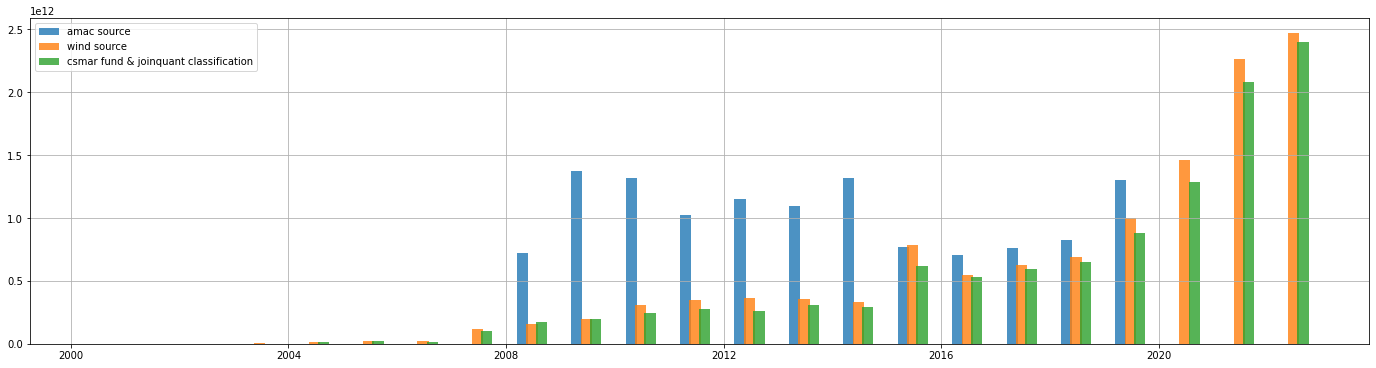

In [156]:
plt.figure(figsize=(24, 6))
plt.bar(amac.股票基金.index - pd.Timedelta('10W'), amac.股票基金.values * 1e8, width=75, label='amac source', alpha=.8)
plt.bar(wind_stock_fund_mkt_value.index - pd.Timedelta('1W'), wind_stock_fund_mkt_value.values, width=75, label='wind source', alpha=.8)
plt.bar(csmar_stock_mkt_value_jq_classify.index + pd.Timedelta('8W'), csmar_stock_mkt_value_jq_classify.values, width=75, label='csmar fund & joinquant classification', alpha=.8)
plt.grid()
plt.legend()

mixed funds market value

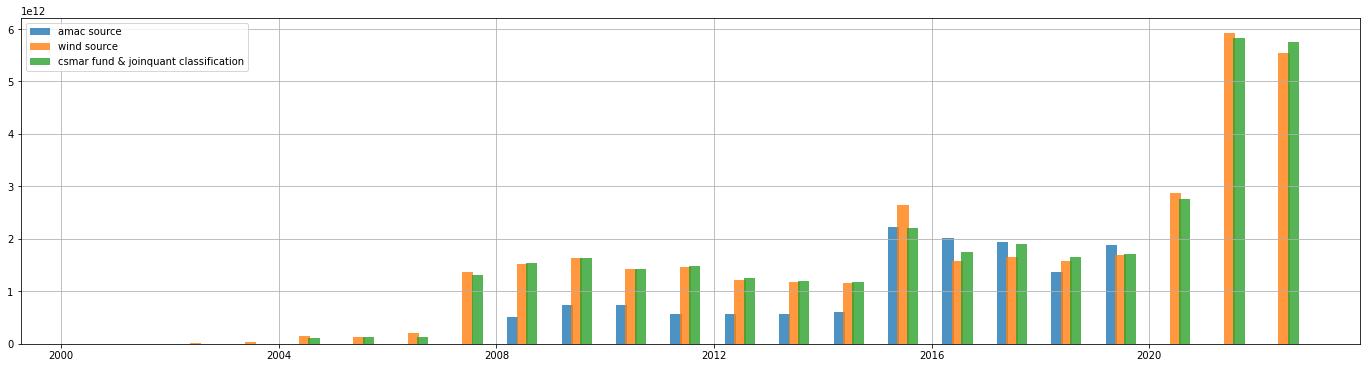

In [157]:
plt.figure(figsize=(24, 6))
plt.bar(amac.混合基金.index - pd.Timedelta('10W'), amac.混合基金.values * 1e8, width=75, label='amac source', alpha=.8)
plt.bar(wind_mixed_fund_mkt_value.index - pd.Timedelta('1W'), wind_mixed_fund_mkt_value.values, width=75, label='wind source', alpha=.8)
plt.bar(csmar_mixed_mkt_value_jq_classify.index + pd.Timedelta('8W'), csmar_mixed_mkt_value_jq_classify.values, width=75, label='csmar fund & joinquant classification', alpha=.8)
plt.grid()
plt.legend()

(stock + mixed) funds market value

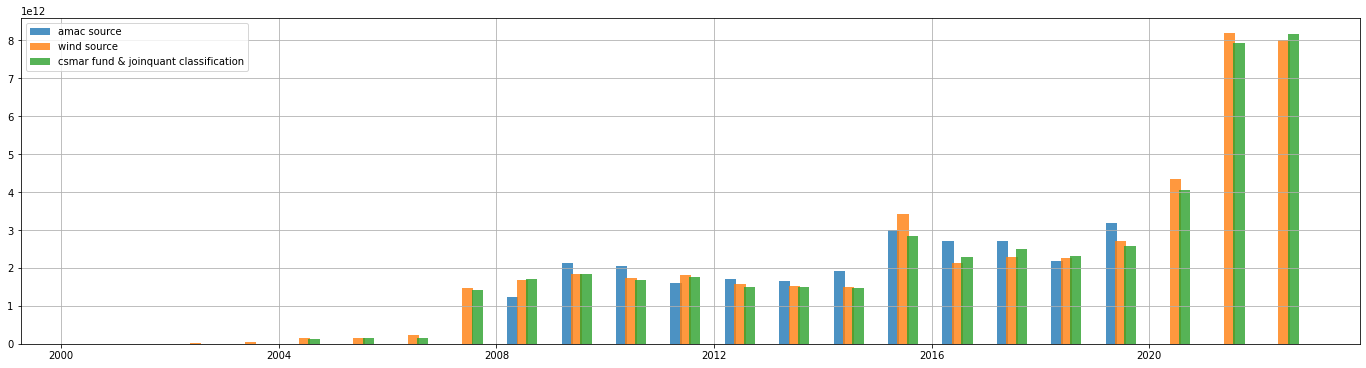

In [158]:
plt.figure(figsize=(24, 6))
plt.bar(amac.混合基金.index - pd.Timedelta('10W'), (amac.混合基金.values + amac.股票基金.values) * 1e8, width=75, label='amac source', alpha=.8)
plt.bar(wind_mixed_fund_mkt_value.index - pd.Timedelta('1W'), \
     wind_mixed_fund_mkt_value.values + wind_stock_fund_mkt_value.values, width=75, label='wind source', alpha=.8)
plt.bar(csmar_mixed_mkt_value_jq_classify.index + pd.Timedelta('8W'), \
     csmar_mixed_mkt_value_jq_classify.values + csmar_stock_mkt_value_jq_classify.values, width=75, label='csmar fund & joinquant classification', alpha=.8)
plt.grid()
plt.legend()

fund counts

In [159]:
csmar_stock_fund_count = nav_monthly.loc[:, csmar_stock_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)
csmar_stock_fund_count.index = csmar_stock_fund_count.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

csmar_mixed_fund_count = nav_monthly.loc[:, csmar_mixed_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)
csmar_mixed_fund_count.index = csmar_mixed_fund_count.index.astype(np.datetime64) + pd.offsets.MonthEnd(0)

integrated plot

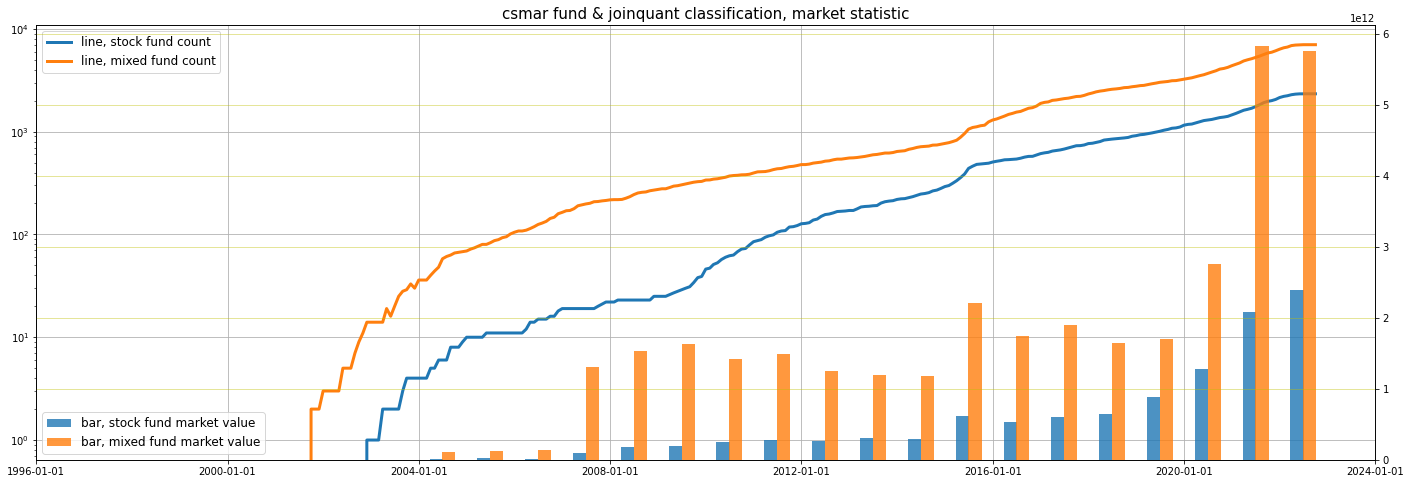

In [160]:
fig, ax1 = plt.subplots()

fig.set_figheight(8)
fig.set_figwidth(24)

nav_monthly_6.loc[:, csmar_mixed_code_6].apply(lambda x: pd.notna(x).sum(), axis=1)

ax1.plot(csmar_stock_fund_count, linewidth=3, label='line, stock fund count')
ax1.plot(csmar_mixed_fund_count, linewidth=3, label='line, mixed fund count')

ax1.set_yscale('log')
ax1.set_yticks([1e0, 1e1, 1e2, 1e3, 1e4])
ax1.grid()

ax2 = ax1.twinx()

plt.bar(csmar_stock_mkt_value_jq_classify.index - pd.Timedelta('7W'), \
     csmar_stock_mkt_value_jq_classify.values, width=100, label='bar, stock fund market value', alpha=.8)

plt.bar(csmar_mixed_mkt_value_jq_classify.index + pd.Timedelta('7W'), \
     csmar_mixed_mkt_value_jq_classify.values, width=100, label='bar, mixed fund market value', alpha=.8)

plt.title('csmar fund & joinquant classification, market statistic', fontsize=15)

ax2.grid(color='y', alpha=.5)
ax2.set_xticks(ax2.get_xticks()[::1])

ax1.legend(loc='upper left', fontsize=12)
ax2.legend(loc='lower left', fontsize=12)

pass

## **III. Filters**

### preview

In [161]:
csmar_jq_co_fund = np.intersect1d(np.char.zfill(nav_daily.Symbol.unique().astype(str), 6), fund_main_info.main_code)
csmar_jq_co_fund = pd.Series(csmar_jq_co_fund, name='main_code')

final_main_info = pd.merge(fund_main_info, csmar_jq_co_fund, on='main_code')[['main_code', 'name', 'operate_mode', 'underlying_asset_type', 'invest_style', 'start_date']]

In [162]:
specs = [[{'type':'domain'}] * 2]

fig = make_subplots(rows=1, cols=2, specs=specs)
fig.add_trace(go.Pie(labels=final_main_info.underlying_asset_type.value_counts().index, values=final_main_info.underlying_asset_type.value_counts().values), 1, 1)
fig.add_trace(go.Pie(labels=final_main_info.operate_mode.value_counts().index, values=final_main_info.operate_mode.value_counts().values), 1, 2)

fig.update_layout(width=1200, height=500)

### 1. static filtering

（1）基金类别为“股票型基金”或“混合型基金”；


（2）基金为“开放式基金”

<!-- （2）非 ETF 类基金；

（3）非 QDII 类基金；

（4）主动管理标识为 1 或者为空； -->



In [163]:
filter_1 = np.logical_or(final_main_info.underlying_asset_type == '股票型', final_main_info.underlying_asset_type == '混合型')
filter_2 = final_main_info.operate_mode == '开放式基金'

filters = [(1, filter_1), (2, filter_2)]
np.array(list(map(lambda _: _[1].sum(), filters))) / len(final_main_info)

# proportional data left

array([0.6202964 , 0.76209063])

In [164]:
def func(previous, now):
    if type(previous) == tuple:
        print(f'filter {previous[0]}: {len(final_main_info)} to {previous[1].sum()}')
        temp = np.logical_and(previous[1], now[1])
        print(f'filter {now[0]}: {previous[1].sum()} to {temp.sum()}')
        return temp
    else:
        temp = np.logical_and(previous, now[1])
        print(f'filter {now[0]}: {previous.sum()} to {temp.sum()}')
        return temp


filters_ = reduce(func, filters)

filter 1: 16397 to 10171
filter 2: 10171 to 7307


In [165]:
final_main_info_ = final_main_info[filters_]
final_main_info_.set_index('main_code').sort_index()

,name,operate_mode,underlying_asset_type,invest_style,start_date
main_code,,,,,
000001,华夏成长,开放式基金,混合型,偏股混合型,2001-12
000006,西部利得量化成长混合,开放式基金,混合型,偏股混合型,2019-03
000011,华夏大盘,开放式基金,混合型,偏股混合型,2004-08
000017,财通可持续混合,开放式基金,混合型,偏股混合型,2013-03
000020,景顺品质,开放式基金,混合型,偏股混合型,2013-03
...,...,...,...,...,...
968045,摩根股息人民币对冲(每月派息),开放式基金,股票型,普通股票型,2019-03
968046,摩根股息美元(累计),开放式基金,股票型,普通股票型,2019-03
968047,摩根股息美元(每月派息),开放式基金,股票型,普通股票型,2019-03


### 2. big table

from `code` indexed only to `code-month` multiIndex

In [166]:
indexes = pd.MultiIndex.from_product([final_main_info_.main_code.sort_values().values, pd.date_range('2002-1', '2022-10', freq='M')])
temp_codes = indexes.get_level_values(0)
temp_date = indexes.get_level_values(1)
main_data = pd.DataFrame(index=indexes)
main_data['main_code'] = temp_codes
main_data['Date'] = temp_date.to_period('M')
main_data = pd.merge(main_data, final_main_info_, on='main_code')
main_data = main_data.rename(columns={'main_code': 'Symbol'})
main_data = main_data.set_index(['Symbol', 'Date'])
main_data

name operate_mode underlying_asset_type invest_style  \
Symbol Date                                                                     
000001 2002-01           华夏成长        开放式基金                   混合型        偏股混合型   
       2002-02           华夏成长        开放式基金                   混合型        偏股混合型   
       2002-03           华夏成长        开放式基金                   混合型        偏股混合型   
       2002-04           华夏成长        开放式基金                   混合型        偏股混合型   
       2002-05           华夏成长        开放式基金                   混合型        偏股混合型   
...                       ...          ...                   ...          ...   
968049 2022-05  摩根股息人民币(每月派息)        开放式基金                   股票型        普通股票型   
       2022-06  摩根股息人民币(每月派息)        开放式基金                   股票型        普通股票型   
       2022-07  摩根股息人民币(每月派息)        开放式基金                   股票型        普通股票型   
       2022-08  摩根股息人民币(每月派息)        开放式基金                   股票型        普通股票型   
       2022-09  摩根股息人民币(每月派息)        开放式基金                   股票型        普通股票型   

               start_date  
Symbol Date                
000001 2002-01    2001-12  
       2002-02    2001-12  
       2002-03    2001-12  
       2002-04    2001-12  
       2002-05    2001-12  
...                   ...  
968049 2022-05    2019-03  
       2022-06    2019-03  
       2022-07    2019-03  
       2022-08    2019-03  
       2022-09    2019-03  

[1819443 rows x 5 columns]

### 3. dynamic filtering

（3）基金上市时间超过一年

（4）最近一次**二季度报/年报/半年报**~~年报或半年报~~披露的中国市场股票持股比例超过总管理规模的30%

In [167]:
main_data = main_data[main_data.index.get_level_values(1) >= main_data.start_date + pd.offsets.MonthEnd(12)]
main_data.index.get_level_values(0).unique()
f'filter 3: {len(final_main_info_)} to {len(main_data.index.get_level_values(0).unique())}'

'filter 3: 7307 to 5847'

*problem*: annual report or semi-annual report not available before 2008

*reason*: regulation rule changed

*solve*: add second quarter report

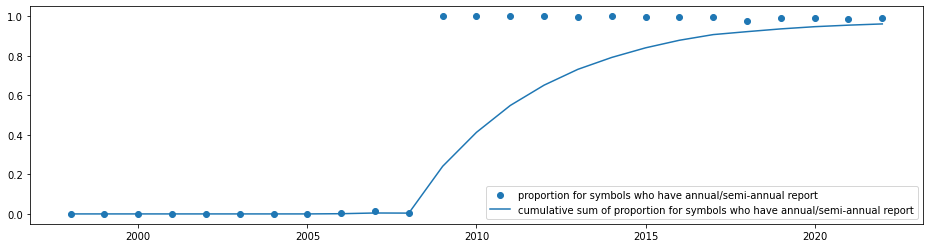

In [168]:
allocation['report_type_check'] = allocation.Date.dt.year
report_type_check = allocation.groupby(['MasterFundCode', 'report_type_check']).apply(lambda temp : 5 in temp.ReportTypeID.values or 6 in temp.ReportTypeID.values)
plt.figure(figsize=(16,4))
report_type_check_ = report_type_check.groupby(level=1).apply(lambda temp: temp.sum() / len(temp))
year_report_count = report_type_check.groupby(level=1).apply(lambda temp: temp.sum())
total_report_count = report_type_check.groupby(level=1).apply(lambda temp: len(temp))
plt.scatter(x=report_type_check_.index, y=report_type_check_.values, label='proportion for symbols who have annual/semi-annual report')
temp = year_report_count.cumsum() / total_report_count.cumsum()
plt.plot(temp.index, temp.values, label='cumulative sum of proportion for symbols who have annual/semi-annual report')
plt.legend()
pass

<img src="attachment/2008_search.png" alt="drawing" width="500"/> <img src="attachment/2009_search.png" alt="drawing" width="508"/>

[中国证券监督管理委员会公告〔2008〕第4号](http://www.gov.cn/zwgk/2008-02/21/content_896020.htm)


使用存在二季度报/年报/半年报的数据

In [169]:
allocation_ = allocation[allocation.ReportTypeID.isin([2, 5, 6])]
allocation_ = pd.merge(allocation_, symbol_code_mapping, on='MasterFundCode', how='left')
allocation_ = allocation_[allocation_.Symbol.isin(main_data.index.get_level_values(0).unique())]

筛选中国市场股票持股比例超过总管理规模的30%

In [170]:
allocation_ = allocation_[(allocation_.Equity / allocation_.TotalAsset) > .3]
print(f'filter 4: {len(main_data.index.get_level_values(0).unique())} to {len(allocation_.Symbol.unique())}')
main_data = main_data.loc[allocation_.Symbol.unique(), slice(None)]

filter 4: 5847 to 5131


### 4. full data

reset nav

In [171]:
nav_monthly_ = pd.Series(nav_monthly.stack().swaplevel(), name='NAV')
nav_monthly_ = pd.DataFrame(nav_monthly_).reset_index()

merge data

In [172]:
main_data = pd.merge(main_data, nav_monthly_, on=['Symbol', 'Date'], how='left').set_index(['Symbol', 'Date'])
main_data = pd.merge(main_data, fund_dividend, on=['Symbol', 'Date'], how='left').set_index(['Symbol', 'Date'])
main_data = pd.merge(main_data, resolution, on=['Symbol', 'Date'], how='left').set_index(['Symbol', 'Date'])

handle NA

In [173]:
main_data['NAV'] = main_data.groupby(level=0).apply(lambda x: x.NAV.fillna(method='ffill')).droplevel(0)
main_data['DividendperShare'] = main_data.DividendperShare.fillna(0)
main_data['SplitRatio'] = main_data.SplitRatio.fillna(1)

In [174]:
main_data

name operate_mode underlying_asset_type invest_style  \
Symbol Date                                                                  
000001 2002-12        华夏成长        开放式基金                   混合型        偏股混合型   
       2003-01        华夏成长        开放式基金                   混合型        偏股混合型   
       2003-02        华夏成长        开放式基金                   混合型        偏股混合型   
       2003-03        华夏成长        开放式基金                   混合型        偏股混合型   
       2003-04        华夏成长        开放式基金                   混合型        偏股混合型   
...                    ...          ...                   ...          ...   
012243 2022-09  东方红内需增长混合B        开放式基金                   混合型        偏股混合型   
910028 2022-06   东方红内需增长混合        开放式基金                   混合型        偏股混合型   
       2022-07   东方红内需增长混合        开放式基金                   混合型        偏股混合型   
       2022-08   东方红内需增长混合        开放式基金                   混合型        偏股混合型   
       2022-09   东方红内需增长混合        开放式基金                   混合型        偏股混合型   

               start_date     NAV  DividendperShare  SplitRatio  
Symbol Date                                                      
000001 2002-12    2001-12  0.9450               0.0         1.0  
       2003-01    2001-12  1.0100               0.0         1.0  
       2003-02    2001-12  1.0140               0.0         1.0  
       2003-03    2001-12  1.0230               0.0         1.0  
       2003-04    2001-12  1.0300               0.0         1.0  
...                   ...     ...               ...         ...  
012243 2022-09    2021-06  3.1259               0.0         1.0  
910028 2022-06    2021-06  3.6542               0.0         1.0  
       2022-07    2021-06  3.6414               0.0         1.0  
       2022-08    2021-06  3.3234               0.0         1.0  
       2022-09    2021-06  3.1545               0.0         1.0  

[249172 rows x 8 columns]

## **IV. Return**

$$
R_t^{real}=\frac{\left(NAV_t+Div_t\right)*SF_t}{NAV_{t-1}*SF_{t-1}}\tag{1}
$$

$NAV_t$ 基金在 $t$ 月末的基金净值

$Div_t$ 在 $t$ 月中发放的现金分红

$SF_t$ 累计拆分因子

当$t$月中发生比例为$s_t$的拆分时, $SF_t=s_tSF_{t-1}$

公式等价于

$$
R_t^{real}=\frac{\left(NAV_t+Div_t\right)*s_t}{NAV_{t-1}}\tag{2}
$$

In [400]:
main_data['NAV_shift'] = main_data.groupby(level=0).apply(lambda x: x.NAV.shift(1)).droplevel(0)
main_data['cumulative_split'] = main_data.groupby(level=0).apply(lambda x: x.SplitRatio.cumprod()).droplevel(0)
main_data['shift_cumulative_split'] = main_data.groupby(level=0).apply(lambda x: x.cumulative_split.shift(1)).droplevel(0)
main_data['shift_SplitRatio'] = main_data.groupby(level=0).apply(lambda x: x.SplitRatio.shift(1)).droplevel(0)

In [401]:
mixed_data = main_data[main_data.underlying_asset_type == '混合型']
stock_data = main_data[main_data.underlying_asset_type == '股票型']

# formula modify here
return_of_stock_fund = stock_data.groupby(level=0).apply(lambda x: ((x.NAV + x.DividendperShare) * x.shift_SplitRatio) / x.NAV_shift).droplevel(0)
return_of_mixed_fund = mixed_data.groupby(level=0).apply(lambda x: ((x.NAV + x.DividendperShare) * x.shift_SplitRatio) / x.NAV_shift).droplevel(0)

[] will not be used


<AxesSubplot:xlabel='Date'>

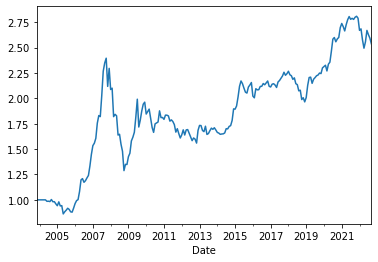

In [402]:
stock_fund_weight = (share_info_6.loc[csmar_co_time_6, csmar_stock_code_6] * nav_monthly_6.loc[csmar_co_time_6, csmar_stock_code_6])
stock_fund_weight = pd.concat([stock_fund_weight, \
    pd.DataFrame([[np.nan] * stock_fund_weight.shape[1]], index=[pd.to_datetime('2023-06').to_period('M')], columns=stock_fund_weight.columns)])
stock_fund_weight = stock_fund_weight.div(stock_fund_weight.sum(axis=1), axis=0)
stock_fund_weight = stock_fund_weight.resample('M').ffill()

stock_fund_dates = return_of_stock_fund.unstack(level=0).index
stock_fund_funds = return_of_stock_fund.unstack(level=0).columns

stock_fund_new = np.setdiff1d(stock_fund_funds, stock_fund_weight.columns)
print(f'{stock_fund_new} will not be used')
stock_fund_funds = np.intersect1d(stock_fund_funds, stock_fund_weight.columns)

(((return_of_stock_fund.unstack(level=0) - 1) * stock_fund_weight.loc[stock_fund_dates, stock_fund_funds]).sum(axis=1) + 1).cumprod().plot()


['960002' '960004'] will not be used


<AxesSubplot:xlabel='Date'>

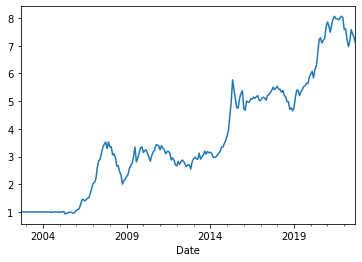

In [403]:
mixed_fund_weight = (share_info_6.loc[csmar_co_time_6, csmar_mixed_code_6] * nav_monthly_6.loc[csmar_co_time_6, csmar_mixed_code_6])
mixed_fund_weight = pd.concat([mixed_fund_weight, \
    pd.DataFrame([[np.nan] * mixed_fund_weight.shape[1]], index=[pd.to_datetime('2023-06').to_period('M')], columns=mixed_fund_weight.columns)])
mixed_fund_weight = mixed_fund_weight.div(mixed_fund_weight.sum(axis=1), axis=0)
mixed_fund_weight = mixed_fund_weight.resample('M').ffill()

mixed_fund_dates = return_of_mixed_fund.unstack(level=0).index
mixed_fund_funds = return_of_mixed_fund.unstack(level=0).columns

mixed_fund_new = np.setdiff1d(mixed_fund_funds, mixed_fund_weight.columns)
print(f'{mixed_fund_new} will not be used')
mixed_fund_funds = np.intersect1d(mixed_fund_funds, mixed_fund_weight.columns)

(((return_of_mixed_fund.unstack(level=0) - 1) * mixed_fund_weight.loc[mixed_fund_dates, mixed_fund_funds]).sum(axis=1) + 1).cumprod().plot()

market value weighted

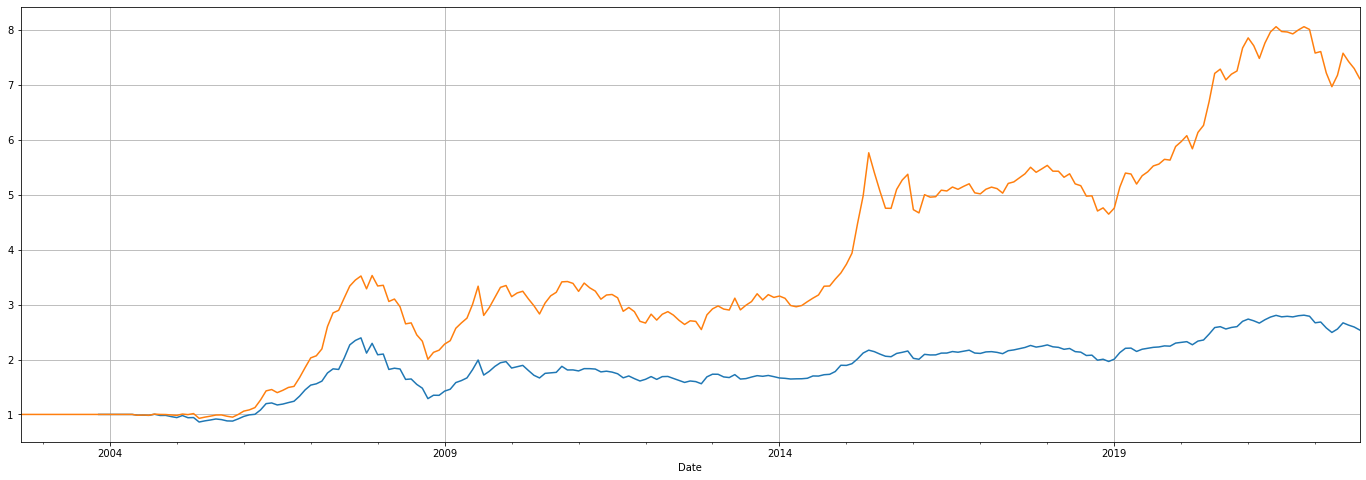

In [404]:
plt.figure(figsize=(24,8))
(((return_of_stock_fund.unstack(level=0) - 1) * stock_fund_weight.loc[stock_fund_dates, stock_fund_funds]).sum(axis=1) + 1).cumprod().plot()
(((return_of_mixed_fund.unstack(level=0) - 1) * mixed_fund_weight.loc[mixed_fund_dates, mixed_fund_funds]).sum(axis=1) + 1).cumprod().plot()
plt.grid()

share equal

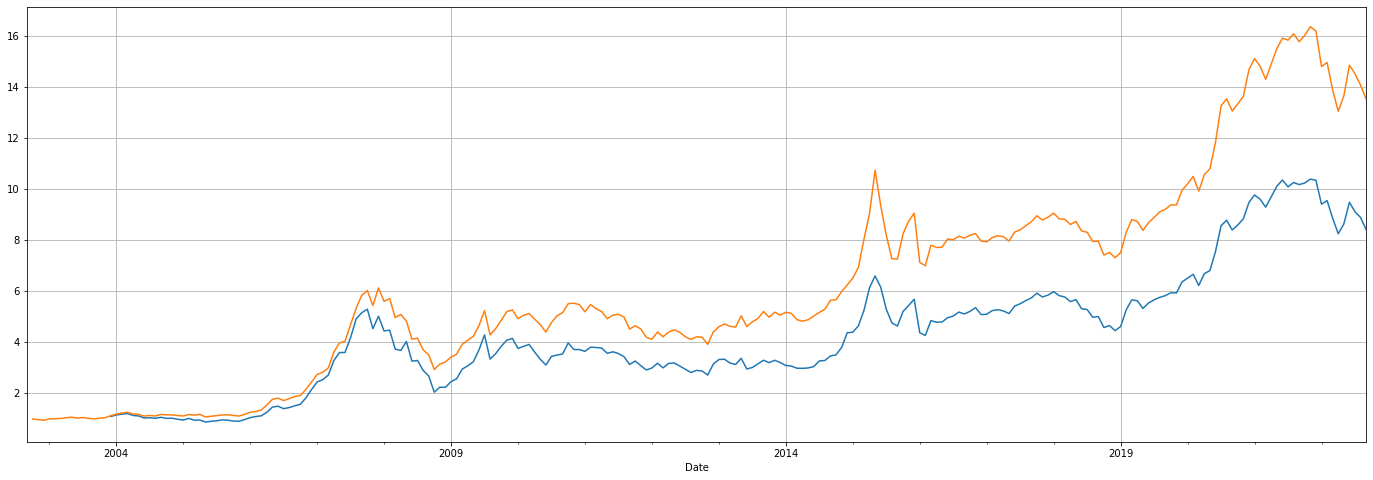

In [405]:
plt.figure(figsize=(24,8))
return_of_stock_fund.groupby(level=1).mean().cumprod().plot()
return_of_mixed_fund.groupby(level=1).mean().cumprod().plot()
plt.grid()

money equal

fund portfolio, here we do not apply money equal strategy

In [406]:
return_of_all = pd.concat([return_of_mixed_fund, return_of_stock_fund])
agg_desc = return_of_all.unstack(level=1).describe()

<AxesSubplot:xlabel='Date'>

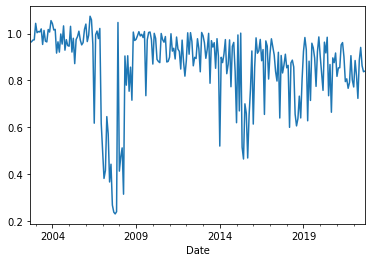

In [407]:
agg_desc.loc['min'].plot()

<AxesSubplot:>

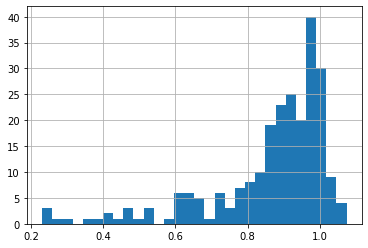

In [408]:
agg_desc.loc['min'].hist(bins=30)

In [409]:
# all funds have positive return
return_of_all.unstack(level=0)[agg_desc.loc['min'] > 1].dropna(how='all', axis=1)
pass

<AxesSubplot:>

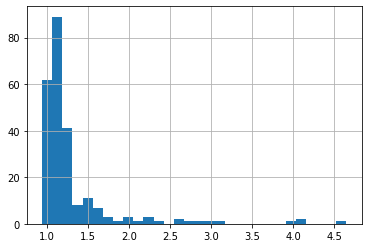

In [410]:
agg_desc.loc['max'].hist(bins=30)

<AxesSubplot:xlabel='Date'>

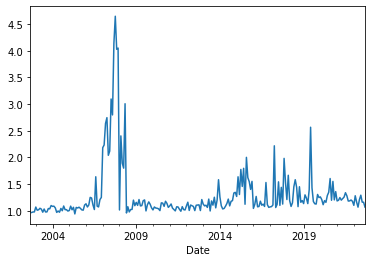

In [411]:
agg_desc.loc['max'].plot()

In [412]:
# all funds have negative return
return_of_all.unstack(level=0)[agg_desc.loc['max'] < 1].dropna(how='all', axis=1)
pass

In [413]:
temp = return_of_all.unstack(level=0)
temp.index = temp.index.astype(np.datetime64)
temp = temp.loc['2006-09-01': '2008-01-01'].dropna(how='all', axis=1)
temp.loc[:, (temp > 4).any()]

Symbol,020005,040001,270005,481001
Date,,,,
2006-09-01,1.021001,1.049931,NaN,1.073775
2006-10-01,1.003863,1.019815,NaN,1.027380
2006-11-01,1.118024,1.127591,NaN,1.150704
2006-12-01,1.147447,1.155083,NaN,1.167283
2007-01-01,1.125500,1.148682,1.136689,1.151879
2007-02-01,1.053754,1.021212,0.984356,0.967931
2007-03-01,1.071248,1.022467,1.076476,1.015998
2007-04-01,1.237308,1.191128,1.217678,1.149899
2007-05-01,1.065522,1.143752,1.118332,1.139073


In [364]:
resolution = pd.read_csv('data/CSMAR/Fund_Resolution.csv', parse_dates=['DeclareDate'])
resolution['Symbol'] = resolution.Symbol.astype(str).str.zfill(6)
resolution = resolution.rename(columns={'DeclareDate': 'Date'})
resolution['SplitRatio'] = resolution.SplitRatio.fillna(1)
# resolution['Date'] = resolution.Date.dt.to_period('M')
resolution

,Symbol,Date,SplitRatio
0,000028,2016-04-21,0.998495
1,000030,2016-04-15,1.851295
2,000053,2018-11-20,1.454000
3,000058,2016-04-22,1.171550
4,000066,2016-04-26,1.411347
...,...,...,...
3741,880007,2020-10-13,1.385466
3742,970044,2021-09-01,1.272947
3743,970080,2021-12-06,1.000000
3744,970087,2021-12-20,1.001735


In [418]:
resolution[resolution.Symbol.isin(['020005', '000030', '970044'])]

,Symbol,Date,SplitRatio
1,000030,2016-04-15,1.851295
517,020005,2007-08-01,3.989181
3742,970044,2021-09-01,1.272947


In [419]:
nav_daily[nav_daily.Symbol == 30].set_index('Date').sort_index().NAV.loc['2016-5-13':'2016-5-20']

Date
2016-05-13    1.851
2016-05-16    1.851
2016-05-17    1.000
2016-05-18    1.000
2016-05-19    1.000
2016-05-20    1.000
Name: NAV, dtype: float64

In [422]:
nav_daily[nav_daily.Symbol == 20005].set_index('Date').sort_index().NAV.loc['2007-8-3':'2007-8-10']

Date
2007-08-03    3.956
2007-08-06    3.994
2007-08-07    3.998
2007-08-08    1.000
2007-08-09    1.005
2007-08-10    1.000
Name: NAV, dtype: float64

In [421]:
nav_daily[nav_daily.Symbol == 970044].set_index('Date').sort_index().NAV.loc['2021-8-25':'2021-9-2']

Date
2021-08-27    1.2609
2021-08-30    1.0000
2021-08-31    0.9988
2021-09-01    0.9927
2021-09-02    0.9928
Name: NAV, dtype: float64

In [423]:
temp = return_of_all.unstack(level=0)
temp.index = temp.index.astype(np.datetime64)
temp = temp.loc['2007-01-01': '2009-01-01'].dropna(how='all', axis=1)
temp.loc[:, (temp > 3.5).any()]

Symbol,020005,040001,270005,481001
Date,,,,
2007-01-01,1.125500,1.148682,1.136689,1.151879
2007-02-01,1.053754,1.021212,0.984356,0.967931
2007-03-01,1.071248,1.022467,1.076476,1.015998
2007-04-01,1.237308,1.191128,1.217678,1.149899
2007-05-01,1.065522,1.143752,1.118332,1.139073
2007-06-01,1.047463,1.001522,1.046149,1.041051
2007-07-01,1.108008,1.170769,1.168295,1.086868
2007-08-01,0.268776,1.098105,1.189968,1.122423
2007-09-01,4.138060,1.038998,0.238739,1.100411


In [424]:
nav_daily[nav_daily.Symbol == 519001].set_index('Date').sort_index().NAV.loc['2007-4-30':'2007-5-14']

Date
2007-04-30    3.1619
2007-05-08    3.2437
2007-05-09    3.2399
2007-05-10    1.0000
2007-05-11    1.0000
2007-05-14    1.0064
Name: NAV, dtype: float64

In [425]:
resolution[resolution.Symbol == '519001']

,Symbol,Date,SplitRatio
3673,519001,2007-04-30,3.232592
